In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import random
from IPython.display import display
from collections import defaultdict
from itertools import islice

In [3]:
# read in + a little bit of cleaning
df = pd.read_csv('../data/text/sample20.txt', sep='\t')
df = df.set_axis(["Time", "Channel", "Signal", "Source", "Dest", "Seq", "SSID", "BSSID"], axis=1)
df["RTime"] = df["Time"] - df["Time"][0]
df = df[["Time", "RTime", "Channel", "Signal", "Seq", "Source", "Dest", "SSID", "BSSID"]]
df = df.drop(["SSID", "BSSID"], axis=1)
df = df.replace("<MISSING>", np.NaN)


# map our channels
freq_map = {2412: 1, 2437: 6, 2462: 11}
df = df.replace({"Channel": freq_map})


display(df)

,Time,RTime,Channel,Signal,Seq,Source,Dest
0,1.667415e+09,0.000000,6,-93.0,1932.0,ee:b0:36:82:b5:bc,ff:ff:ff:ff:ff:ff
1,1.667415e+09,0.020600,6,-91.0,1933.0,ee:b0:36:82:b5:bc,ff:ff:ff:ff:ff:ff
2,1.667415e+09,0.077403,6,-89.0,1027.0,1e:9d:26:88:08:a1,ff:ff:ff:ff:ff:ff
3,1.667415e+09,0.101553,6,-93.0,1028.0,1e:9d:26:88:08:a1,ff:ff:ff:ff:ff:ff
4,1.667415e+09,0.178932,11,-87.0,2551.0,"2c:17:72:83:ec:a4,2c:17:72:83:ec:a4",NaN
...,...,...,...,...,...,...,...
93596,1.667419e+09,3762.706455,1,-97.0,152.0,a4:83:e7:62:09:23,ff:ff:ff:ff:ff:ff
93597,1.667419e+09,3762.746851,6,-68.0,3723.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff
93598,1.667419e+09,3762.768871,6,-65.0,3724.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff
93599,1.667419e+09,3762.799703,1,-88.0,2613.0,4a:75:3c:73:ae:e7,ff:ff:ff:ff:ff:ff


Let's get rid of any 96 bit MAC addresses.

In [4]:
# df = df[ df["Source"].str.len() < 20]
# df = df[ df["Dest"].str.len() < 20]

If we take a look at the probe requests that come in over 5 minutes, we can see that there appears to be a constant stream of them, which makes separating probe requests into buckets rather difficult:

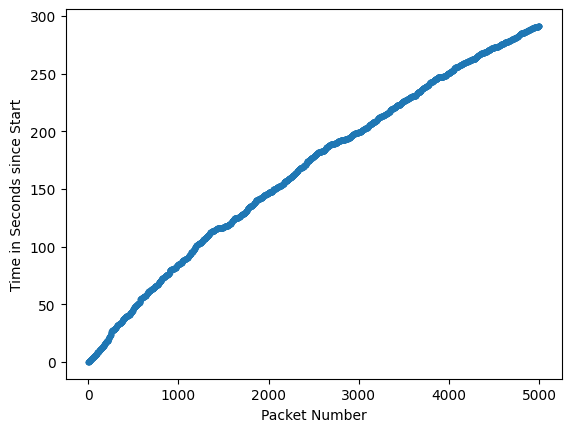

In [5]:
ax = df.iloc[0:5000]["RTime"].plot(style=".")
ax.set_ylabel("Time in Seconds since Start")
ax.set_xlabel("Packet Number")
plt.show()

Let's use our previous value of -45 and see what we come up with

In [6]:
cutoff = -42
filtered = df[df["Signal"] > cutoff]
display(filtered)

,Time,RTime,Channel,Signal,Seq,Source,Dest
1432,1.667415e+09,115.675633,6,-33.0,1502.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1433,1.667415e+09,115.753851,6,-38.0,1507.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1434,1.667415e+09,115.755477,6,-36.0,1508.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1436,1.667415e+09,115.794135,6,-36.0,1510.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
1437,1.667415e+09,115.795554,6,-37.0,1511.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
...,...,...,...,...,...,...,...
91692,1.667418e+09,3662.680313,6,-37.0,948.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91693,1.667418e+09,3662.681734,6,-39.0,949.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91695,1.667418e+09,3662.683328,6,-36.0,950.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff
91696,1.667418e+09,3662.718581,6,-39.0,951.0,e8:50:8b:43:b1:20,ff:ff:ff:ff:ff:ff


Only 420 entries! Let's see if theres any source MAC that shows up multiple times:

In [7]:
filtered.groupby("Source")["Time"].count()

Source
70:c1:9a:9b:b0:87      1
74:a8:85:54:7c:80      1
a3:10:c7:cb:b5:20      1
c7:26:2d:cc:28:16      1
d1:a1:16:87:62:41      1
e0:cd:8f:73:b0:20      1
e8:10:17:85:0c:b3      1
e8:10:eb:01:04:91      1
e8:50:8b:43:b1:20    411
fa:50:8b:43:60:95      1
Name: Time, dtype: int64

With a cutoff of -42, we can see that our target phone shows up 411 times while also have very little noise. We'll want to tweak this so we don't remove all of the other phones (since we're trying to capture it naturally). At this point, we can group together timestamps to form our clusters. We won't be using any fancy stats to separate them for now, and instead requests into clusters that are atleast 5 seconds away from the next probe.

In [8]:
x = filtered[["RTime", "Source"]].to_numpy()

dt  = np.diff(x[:, 0])
pos = np.where(dt > 5)[0] + 1
split = list(np.split(x, pos))

res = []
a = 1
for cluster in split:
    for time, addr in cluster:
        res.append([time, a, addr])
    
    a += 1
    
        
        
su = DataFrame(res, columns=["Time", "Cluster", "Source"])
su = su.astype({"Time": np.float64, "Cluster": np.int32, "Source": str})
display(su)

,Time,Cluster,Source
0,115.675633,1,e8:50:8b:43:b1:20
1,115.753851,1,e8:50:8b:43:b1:20
2,115.755477,1,e8:50:8b:43:b1:20
3,115.794135,1,e8:50:8b:43:b1:20
4,115.795554,1,e8:50:8b:43:b1:20
...,...,...,...
415,3662.680313,28,e8:50:8b:43:b1:20
416,3662.681734,28,e8:50:8b:43:b1:20
417,3662.683328,28,e8:50:8b:43:b1:20
418,3662.718581,28,e8:50:8b:43:b1:20


In [9]:
su.groupby(["Cluster", "Source"]).count().head(10)

Time
Cluster Source                 
1       e8:50:8b:43:b1:20    11
2       d1:a1:16:87:62:41     1
        e8:50:8b:43:b1:20    14
        fa:50:8b:43:60:95     1
3       e8:50:8b:43:b1:20    14
4       e8:50:8b:43:b1:20    16
5       e8:50:8b:43:b1:20    15
6       e8:50:8b:43:b1:20    15
7       e8:50:8b:43:b1:20    16
8       e8:50:8b:43:b1:20    13

We can see that our samsung phone `(e8:50:8b:43:b1:20)` dominates most of these clusters and sends approximately 15 packets each scan. We'll use this value to determine how many devices are scanning at once. Now let's take a look at the time differences between clusters:

In [10]:
display(su.groupby("Cluster")["Time"].mean().diff())

Cluster
1            NaN
2     131.402620
3     131.372642
4     131.384366
5     131.370388
6     131.407102
7     131.365429
8     131.389767
9     131.387592
10    131.369921
11    131.369204
12    131.374956
13    131.387628
14    131.371534
15    131.396517
16    131.391468
17    131.370650
18    131.373426
19    131.377847
20    131.378606
21    131.384845
22    131.281726
23    131.291287
24    131.379164
25    131.270180
26    131.278180
27    131.273859
28    131.386928
Name: Time, dtype: float64

Interesting, we can see that scans are around 131 seconds apart. Naturally this is because we are only capturing the single device.

In [11]:
cutoff = -70
filtered = df[df["Signal"] > cutoff]
display(filtered)

,Time,RTime,Channel,Signal,Seq,Source,Dest
12,1.667415e+09,0.714278,11,-69.0,818.0,b2:ca:df:3e:5a:6c,ff:ff:ff:ff:ff:ff
209,1.667415e+09,18.026169,6,-67.0,3774.0,ca:e0:b4:d4:55:b0,ff:ff:ff:ff:ff:ff
210,1.667415e+09,18.028502,6,-66.0,3775.0,ca:e0:b4:d4:55:b0,ff:ff:ff:ff:ff:ff
211,1.667415e+09,18.052317,6,-68.0,3776.0,ca:e0:b4:d4:55:b0,ff:ff:ff:ff:ff:ff
212,1.667415e+09,18.073020,6,-67.0,3777.0,ca:e0:b4:d4:55:b0,ff:ff:ff:ff:ff:ff
...,...,...,...,...,...,...,...
93520,1.667419e+09,3756.028207,6,-68.0,441.0,96:77:69:e4:22:24,ff:ff:ff:ff:ff:ff
93521,1.667419e+09,3756.062195,6,-67.0,442.0,96:77:69:e4:22:24,ff:ff:ff:ff:ff:ff
93522,1.667419e+09,3756.099246,11,-69.0,444.0,96:77:69:e4:22:24,ff:ff:ff:ff:ff:ff
93597,1.667419e+09,3762.746851,6,-68.0,3723.0,ce:0f:b4:ce:d4:93,ff:ff:ff:ff:ff:ff


In [12]:
filtered.groupby("Source")["Time"].count().sort_values(ascending=False)

Source
e8:50:8b:43:b1:20    1057
c8:94:02:47:62:31    1006
4e:24:a6:52:15:00     312
3c:a6:f6:2f:ff:50     262
b0:fc:36:ca:fe:27     154
                     ... 
7e:47:b2:30:eb:02       1
7e:8c:a4:16:46:a4       1
7e:c9:32:f1:b4:bd       1
02:7b:93:7a:a4:b2       1
fe:d9:5e:0e:15:b0       1
Name: Time, Length: 400, dtype: int64

It appears that there are only a few addresses that do not use MAC randomization.

In [13]:
x = filtered[["RTime", "Source"]].to_numpy()

dt  = np.diff(x[:, 0])
pos = np.where(dt > 5)[0] + 1
split = list(np.split(x, pos))

res = []
a = 1
for cluster in split:
    for time, addr in cluster:
        res.append([time, a, addr])
    
    a += 1
    
        
        
su = DataFrame(res, columns=["Time", "Cluster", "Source"])
su = su.astype({"Time": np.float64, "Cluster": np.int32, "Source": str})
display(su)

,Time,Cluster,Source
0,0.714278,1,b2:ca:df:3e:5a:6c
1,18.026169,2,ca:e0:b4:d4:55:b0
2,18.028502,2,ca:e0:b4:d4:55:b0
3,18.052317,2,ca:e0:b4:d4:55:b0
4,18.073020,2,ca:e0:b4:d4:55:b0
...,...,...,...
4474,3756.028207,239,96:77:69:e4:22:24
4475,3756.062195,239,96:77:69:e4:22:24
4476,3756.099246,239,96:77:69:e4:22:24
4477,3762.746851,240,ce:0f:b4:ce:d4:93


We know that each cluster should have around 15 probe requests based on our earlier observations. Let's filter out any clusters with less than 10 requests.

In [23]:
x = su.groupby("Cluster")["Time"].count() > 10 # contains all clusters that have more than 10 elements
su = su[su.groupby('Cluster')['Time'].transform('size') >= 10]
display(su)

,Time,Cluster,Source
7,37.341094,4,08:5b:d6:a1:44:cf
8,37.345560,4,08:5b:d6:a1:44:cf
9,39.512421,4,a6:d8:79:8f:35:37
10,39.533577,4,a6:d8:79:8f:35:37
11,39.603077,4,a6:d8:79:8f:35:37
...,...,...,...
4457,3733.354481,237,b0:fc:36:ca:fe:27
4458,3733.805420,237,b0:fc:36:ca:fe:27
4459,3733.806395,237,b0:fc:36:ca:fe:27
4460,3733.807402,237,b0:fc:36:ca:fe:27


Now let's see the mean values from each of these clusters:

In [71]:
means = su.groupby("Cluster")["Time"].mean().to_frame()
means["nRequests"] = su.groupby("Cluster")["Time"].count()
display(means.sort_values(by="Time"))

,Time,nRequests
Cluster,,
4,40.492016,13
9,118.594901,58
17,231.299599,13
18,246.968416,53
23,311.220473,24
...,...,...
222,3531.230222,36
230,3628.049464,11
232,3664.784520,59


And the differences between them:

In [76]:
diffs = means["Time"].diff()
display(diffs)

Cluster
4        NaN
9       78.0
17     113.0
18      15.0
23      65.0
       ...  
222     61.0
230     97.0
232     36.0
236     49.0
237     19.0
Name: Time, Length: 121, dtype: float64

If we assume each phone sends around 15 requests, each cluster will have N / 15 devices transmitting at that time (where N is the number of requests in that cluster)

In [78]:
means["nDev"] = round(means["nRequests"] / 15).map(int)
means["Time"] = means["Time"].map(int)
display(means)

,Time,nRequests,nDev
Cluster,,,
4,40,13,1
9,118,58,4
17,231,13,1
18,246,53,4
23,311,24,2
...,...,...,...
222,3531,36,2
230,3628,11,1
232,3664,59,4


Now, let's create a graph where each node is identified by the time of the cluster. Nodes N1 and N2 have an edge between them if the time difference between them is under 160 seconds. 

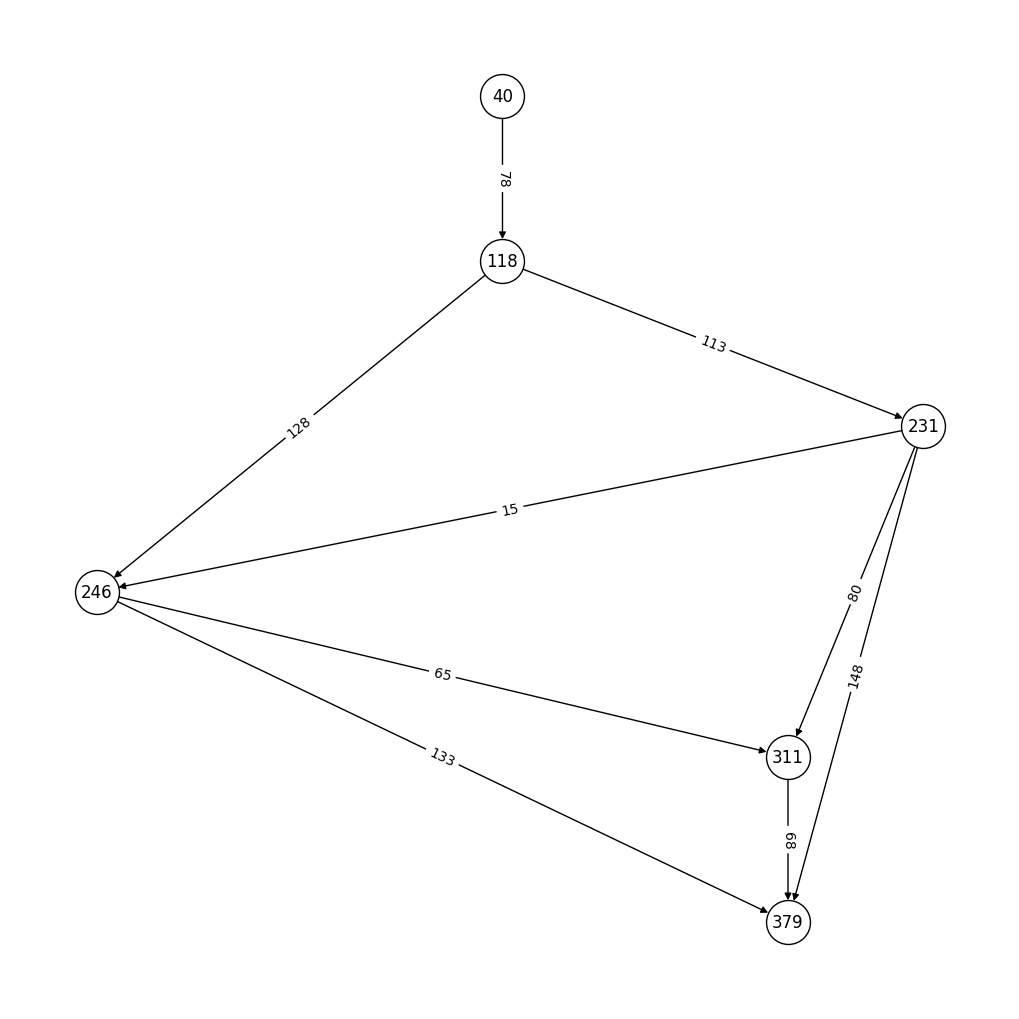

In [163]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

G = nx.DiGraph()
nodes = means[["Time", "nDev"]].loc[0:30, :].to_numpy()

for time, dev in nodes:
     G.add_node(time, nDev=dev)


for start in nodes:
    for end in nodes:
        
        if end[0] < start[0] or end[0] == start[0]:
            continue
            
        node_diff = end[0] - start[0]
            
        if node_diff <= 160:
            
            G.add_edge(start[0], end[0], val=node_diff)
            

            
            
options = {
    "font_size": 12,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    "with_labels": True
}
    

fig = plt.figure(1, figsize=(10, 10))
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, **options)
edge_labels = nx.get_edge_attributes(G,'val')
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()